# Basics of non-line-of-sight imaging with `y-tal`

## Overview
In this tutorial, you will compute your first reconstructions using `y-tal`.


<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>
  
  Import `y-tal` and load non-line-of-sight capture data generated using `tal render`.
  
  </li>
  <li>
  
  Specify the reconstruction volume.
  
  </li>
  <li>
  
  Compute and visualize a reconstruction.
  
  </li>
  <li>
  
  Different strategies to ensure reconstruction is efficient: downscaling, multithreading and efficient propagators.
  
  </li>
  <li>
  
  Visualize ground truth information about the hidden scene: depth and normals.
  
  </li>
</ul>

</div>

In [2]:
import tal
print('Executed using tal version:', tal.__version__)

# If you want to follow this tutorial,
# you need to first obtain this file, either by running
# the corresponding `render` tutorial, or by downloading it
# (see the top-level README on the examples/ folder)
filename = 'data/tal/z-single-64x64.hdf5'

data = tal.io.read_capture(filename)

Executed using tal version: 0.21.0


Text(0.5, 1.0, 'Response at H(sensor_x=32, sensor_y=32)')

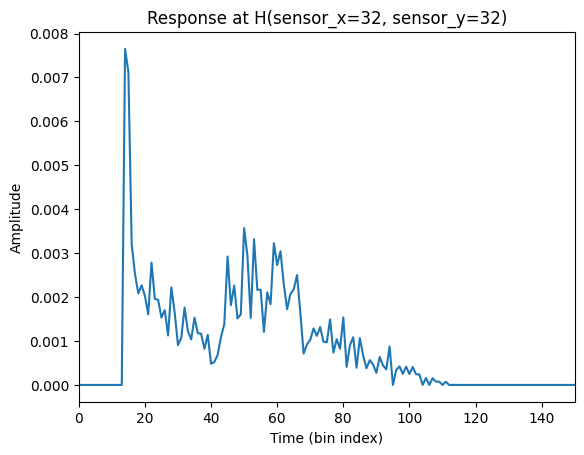

In [11]:
import matplotlib.pyplot as plt

plt.plot(data.H[:, 32, 32])
plt.xlim(0, 150)
plt.xlabel('Time (bin index)')
plt.ylabel('Amplitude')
plt.title('Response at H(sensor_x=32, sensor_y=32)')

Because this is a test scene, we know that the hidden geometry is placed at Z=1

We provide two functions to define the reconstruction volume:
* `tal.reconstruct.get_volume_project_rw(data, depths)`: This generates a plane that is coplanar to the relay wall, by displacing all sensor positions along the depth axis by the distances defined in the `depths` parameter (see below).
* `tal.reconstruct.get_volume_min_max_resolution(data, minimal_pos, maximal_pos, resolution)`: Generates a volume using two points `{minimal|maximal}_pos` with voxel resolution `resolution`.

In [4]:
volume_xyz = tal.reconstruct.get_volume_project_rw(data, depths=[1.0,])
print(volume_xyz.shape)

(64, 64, 1, 3)


Here is a reconstruction using the filtered backprojection algorithm. By default:
* The filtering applied, by default, is the phasor field filter with the `wl_mean` and `wl_sigma` specified
* It is single-threaded (see `tal.resources` later to see how to multi-thread)

Note how we use the `tal.plot.amplitude_phase` to plot 2D complex data. This is just a shortcut with the necessary calls to `matplotlib.pyplot` below. You can also check `tal.plot.volume` which produces a 3D plot using `pyvista`.

tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 60.07it/s]


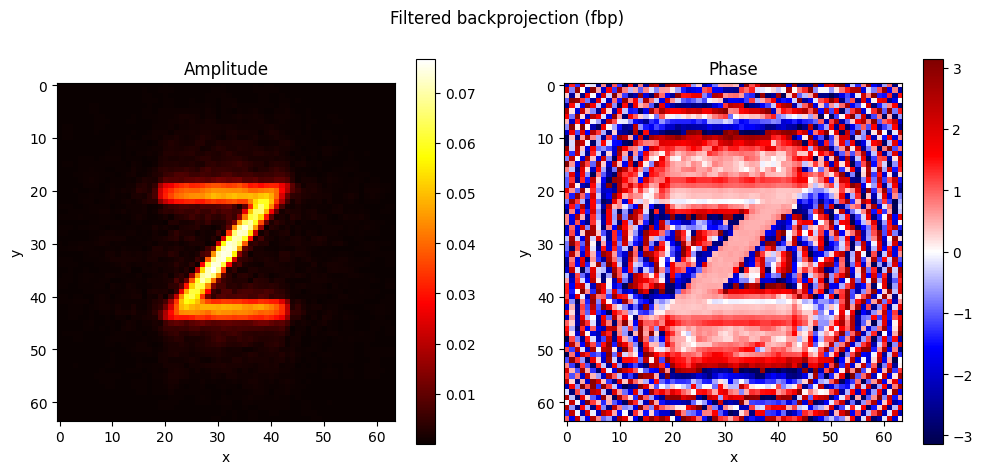

In [5]:
H_1 = tal.reconstruct.fbp.solve(data,
                                wl_mean=0.06, wl_sigma=0.06,
                                volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
tal.plot.amplitude_phase(H_1, title='Filtered backprojection (fbp)')

We can also downscale the data by grouping several pixels in groups of NxN from the impulse response using the `downscale(N)` function. This greatly speeds up the reconstruction (which is more useful in cases more complex than this tutorial). However as you can see the result is a bit degraded (we exaggerated this for the tutorial, feel free to modify N, e.g., this case with N=2 would work better, but feel free to try 2, 4, 8, 16, etc.)

Downscaled from 64x64 to 16x16
tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 1266.91it/s]


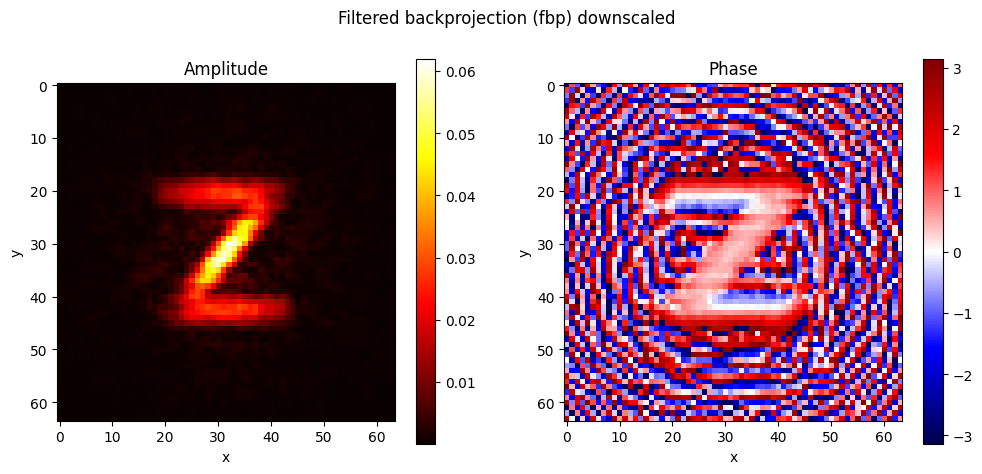

In [6]:
data_2 = tal.io.read_capture(filename)
data_2.downscale(4)
H_1 = tal.reconstruct.fbp.solve(data_2,
                                wl_mean=0.06, wl_sigma=0.06,
                                volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
tal.plot.amplitude_phase(H_1, title='Filtered backprojection (fbp) downscaled')

We can use `tal.resources` to divide the work among different threads. For this case it does not matter that much, as it is a simple experiment.

The parameter allows you to set the number of threads.

If you don't like the amount of logs that are output in this case, feel free to `tal.set_log_level(tal.LogLevel.WARNING)`, which will suppress many messages.

tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m
tal.resources: Using 32 CPU processes and downscale 32
tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3
tal.resources: Using 32 CPU processes and downscale 32


tal.resources progress: 100%|██████████| 32/32 [00:00<00:00, 636102.98it/s]


tal.resources progress: 100%|██████████| 32/32 [00:00<00:00, 72082.56it/s]


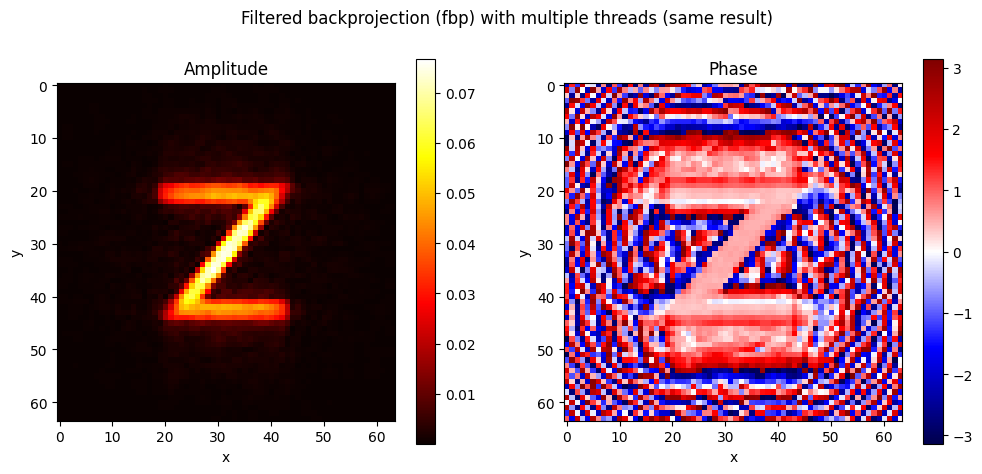

In [7]:
#with tal.resources(4):  # 4 threads
with tal.resources('max'):  # max number of threads
    H_1 = tal.reconstruct.fbp.solve(data,
                                    wl_mean=0.06, wl_sigma=0.06,
                                    volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
    tal.plot.amplitude_phase(H_1, title='Filtered backprojection (fbp) with multiple threads (same result)')

Finally, other algorithms might be faster. For example, `pf_dev` introduces optimized plane-to-plane light propagation operators using convolutions in the Fourier domain, which results in a much lower memory and time requirement.

tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3
tal.reconstruct.utils: Optimizing for camera convolutions.
tal.reconstruct.pf_dev: Using 41 wavelengths from 0.0400m to 0.1200m
tal.reconstruct.pf_dev: projector_focus_mode=confocal
tal.reconstruct.pf_dev: Computing FFT for H_0
tal.reconstruct.pf_dev: Will use divide_frequencies implementation


tal.reconstruct.pf_dev divide-frequency: 100%|██████████| 41/41 [00:00<00:00, 842.05it/s]


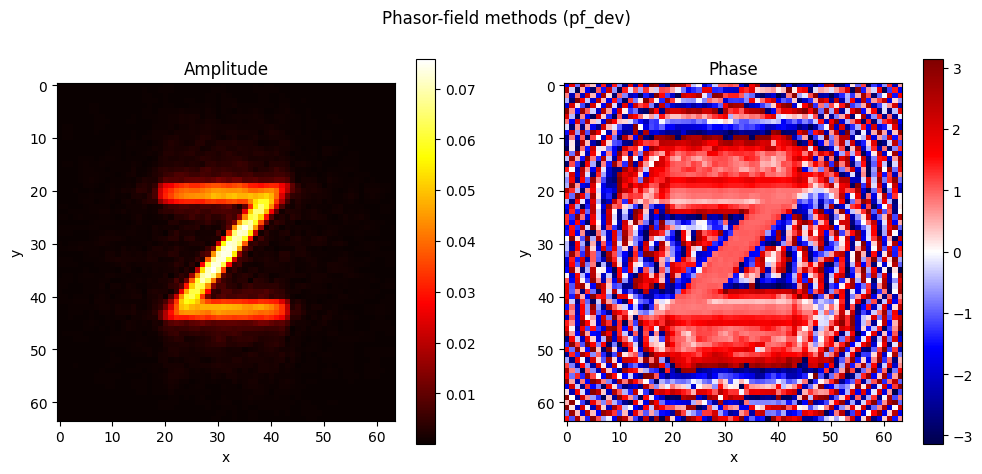

In [8]:
# When your volume_xyz is coplanar to the relay wall,
# pf_dev implements the optimization in the Phasor Field Diffraction paper
# which can be even faster
H_1 = tal.reconstruct.pf_dev.solve(data,
                                   wl_mean=0.06, wl_sigma=0.06,
                                   volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
tal.plot.amplitude_phase(H_1, title='Phasor-field methods (pf_dev)')

Finally, renders done using `tal render` also generate ground truth information by default, here we show how to read and display it:

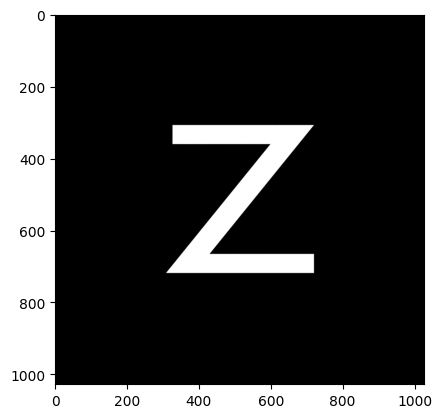

In [9]:
# Ground truth depth and normals data
import matplotlib.pyplot as plt

depth = data.scene_info['ground_truth']['depth'][..., 2]

plt.imshow(depth, cmap='gray')

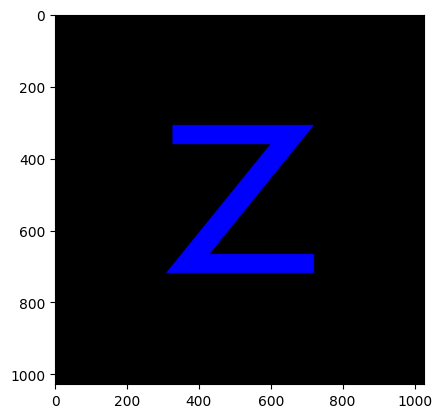

In [10]:
import numpy as np

# Normals are (0, 0, -1) (along negative depth axis i.e. towards relay wall)
normals = data.scene_info['ground_truth']['normals']

plt.imshow(np.clip(normals * -1, 0, 1))